# Split-MNIST Classification Showdown

## 0. Imports and Load Dataset

In [1]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree
import torchvision
import optax

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [5]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./data', train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

train = (images, labels)
test = (images_test, labels_test)

In [6]:
X_train, y_train = jnp.expand_dims(jnp.expand_dims(jnp.array(images), -1), 1), jnp.array(labels.ravel()).astype(float)
X_test, y_test = jnp.expand_dims(jnp.expand_dims(jnp.array(images_test), -1), 1), jnp.array(labels_test.ravel()).astype(float)

Generate the Split-MNIST Dataset

In [7]:
train_set_by_digit_pair, test_set_by_digit_pair = {}, {}

for i in range(10//2):
    curr_pair = (2*i, 2*i+1)
    
    # Train set
    train_indx = (y_train == 2*i) | (y_train == 2*i+1)
    train_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_train[train_indx], y_train[train_indx]-2*i)

    # Test set
    test_indx = (y_test == 2*i) | (y_test == 2*i+1)
    test_set_by_digit_pair[str(2*i)+str(2*i+1)] = (X_test[test_indx], y_test[test_indx]-2*i)

Callback function to evaluate NLL

In [8]:
def nll_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = vmap(apply_fn, (None, 0))(bel.mean, X_test).squeeze()
    nll = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y_test))
    
    res = {
        "test": nll,
    }
    return res

In [9]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    logits = jit(apply_fn)(bel.mean, X_test).squeeze()
    nll_test = jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y_test))
    
    # One-step-ahead NLL
    nll_ose = jnp.mean(optax.sigmoid_binary_cross_entropy(y.squeeze(), pred.mean.squeeze()))
    
    res = {
        "nll_test": nll_test,
        "nll_ose": nll_ose,
    }
    return res

# 1. Model Setup

In [10]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = x.ravel()
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
key = jr.PRNGKey(1)
dim_out = 1
dim_in = (28, 28, 1)
model = MLP(dim_out, activation=nn.elu)
params = model.init(key, jnp.ones((1, *dim_in)))
flat_params, unflatten_fn = ravel_pytree(params)
n_params = len(flat_params)
print(f'flat_params.shape: {flat_params.shape}')

# Define apply function
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

mlp_apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

flat_params.shape: (16141,)


In [11]:
class CNN(nn.Module):
    """A simple CNN model."""
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

key = jr.PRNGKey(0)
cnn_model = CNN()
cnn_params = cnn_model.init(key, jnp.ones((1, 28, 28, 1)))
cnn_flat_params, cnn_unflatten_fn = ravel_pytree(cnn_params)
print(f'flat_params.shape: {cnn_flat_params.shape}')

cnn_apply_fn = partial(apply, model=cnn_model, unflatten_fn=cnn_unflatten_fn)

flat_params.shape: (420481,)


# 2. MLP Model

In [12]:
sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(mlp_apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
emission_mean_function = lambda w, x: sigmoid_fn(w, x)
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

## 2.1 FCEKF

### 2.1.1 Digits 0 & 1 (Hyperparams Tuning)

In [13]:
n_warmup = 2_000

X_01_train, y_01_train = train_set_by_digit_pair['01']
X_01_warmup, y_01_warmup = X_01_train[:n_warmup], y_01_train[:n_warmup]
warmup_01_train = (X_01_warmup[:-200], y_01_warmup[:-200])
warmup_01_test = (X_01_warmup[-200:], y_01_warmup[-200:])

X_01_learn, y_01_learn = X_01_train[n_warmup:], y_01_train[n_warmup:]

X_test_01, y_test_01 = test_set_by_digit_pair['01']

In [14]:
pbounds = {
    "log_init_cov": (-5.0, 0.0),
    "dynamics_weights": (0.0, 1.0),
}

In [15]:
fcekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_01_train, warmup_01_test, nll_callback, 'vdekf',
    emission_mean_function, emission_cov_function
)

In [16]:
%%time
fcekf_optimizer.maximize(
    init_points=25,
    n_iter=25,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
| 1         | -0.6886   | 0.9169    | -2.057    |
| 2         | -0.6827   | 0.265     | -1.084    |
| 3         | -0.3008   | 0.918     | -0.8632   |
| 4         | -0.6919   | 0.728     | -3.698    |
| 5         | -0.6922   | 0.9118    | -3.696    |
| 6         | -0.6918   | 0.7664    | -3.692    |
| 7         | -0.6912   | 0.1223    | -3.07     |
| 8         | -0.6917   | 0.8401    | -3.609    |
| 9         | -0.6875   | 0.06991   | -1.834    |
| 10        | -0.6879   | 0.5848    | -2.094    |
| 11        | -0.6851   | 0.6772    | -1.564    |
| 12        | -0.6916   | 0.4389    | -3.395    |
| 13        | -0.6898   | 0.5706    | -2.601    |
| 14        | -0.6814   | 0.8611    | -0.826    |
| 15        | -0.6928   | 0.1058    | -4.698    |
| 16        | -0.6823   | 0.5969    | -1.038    |
| 17        | -0.6891   | 0.2264    | -2.324    |


KeyboardInterrupt: 

# 3. CNN Model

In [13]:
cnn_sigmoid_fn = lambda w, x: jnp.clip(jax.nn.sigmoid(cnn_apply_fn(w, x)), 1e-4, 1-1e-4).ravel()
cnn_emission_mean_function = lambda w, x: cnn_sigmoid_fn(w, x)
cnn_emission_cov_function = lambda w, x: cnn_sigmoid_fn(w, x) * (1 - cnn_sigmoid_fn(w, x))

## 3.1 FDEKF

### 3.1.1 Digits 0 & 1 (First Training)

In [14]:
n_warmup = 2_000

X_01_train, y_01_train = train_set_by_digit_pair['01']
X_01_warmup, y_01_warmup = X_01_train[:n_warmup], y_01_train[:n_warmup]
warmup_01_train = (X_01_warmup[:-200], y_01_warmup[:-200])
warmup_01_test = (X_01_warmup[-200:], y_01_warmup[-200:])

X_01_learn, y_01_learn = X_01_train[n_warmup:], y_01_train[n_warmup:]

X_test_01, y_test_01 = test_set_by_digit_pair['01']

In [15]:
pbounds = {
    "log_init_cov": (-5.0, 0.0),
    "dynamics_weights": (0.0, 1.0),
}

In [16]:
fdekf_optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    cnn_model, pbounds, 314, warmup_01_train, warmup_01_test, nll_callback, 'fdekf',
    cnn_emission_mean_function, cnn_emission_cov_function
)

In [18]:
%%time
fdekf_optimizer.maximize(
    init_points=10,
    n_iter=15,
)

In [44]:
test_kwargs = {"X_test": X_test_01, "y_test": y_test_01, "apply_fn": cnn_apply_fn}
# fdekf_hparams = hp_ekf.get_best_params(n_params, fdekf_optimizer, method="fdekf")
# fdekf_hparams.pop('emission_cov_function')
fdekf_hparams = {
    'dynamics_weights': 1.0,
    'dynamics_covariance': None,
    'initial_covariance': jnp.power(10, -5.0).item(),
}
fd_ekf_estimator = hp_ekf.build_estimator(cnn_flat_params, fdekf_hparams, None, cnn_apply_fn, method="fdekf", 
                                          emission_mean_function=cnn_emission_mean_function,
                                          emission_cov_function=cnn_emission_cov_function)

In [47]:
bel_01_fd_ekf, output_01_fd_ekf = fd_ekf_estimator.scan(
    warmup_01_train[0], warmup_01_train[1], callback=eval_callback, progress_bar=True, **test_kwargs
)

  0%|          | 0/900 [00:00<?, ?it/s]

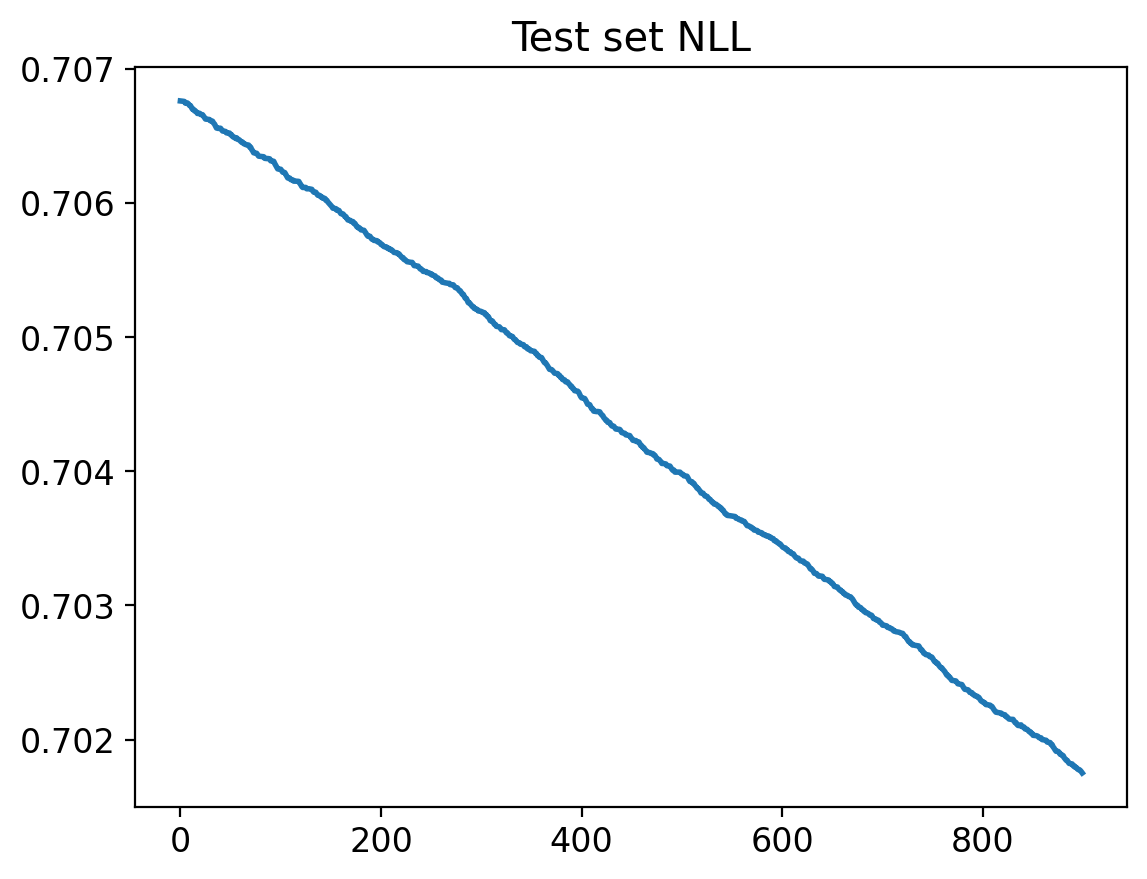

In [62]:
fig, ax = plt.subplots()
ax.plot(output_01_fd_ekf['nll_test']);
ax.set_title('Test set NLL');

In [49]:
colors = {
    # "lofi-of": "tab:blue",
    # "lofi-oa": "tab:orange",
    # "lofi-ff": "tab:red",
    # "lofi-fa": "tab:pink",
    # "orfit": "tab:green",
    "fd-ekf": "tab:purple",
}

In [52]:
methods = {
    # "lofi-of": output_lofi_of,
    # "lofi-oa": output_lofi_oa,
    # "lofi-ff": output_lofi_ff,
    # "lofi-fa": output_lofi_fa,
    # "orfit":   output_orfit,
    "fd-ekf": output_01_fd_ekf,
}

methods = jax.tree_map(np.array, methods)

In [53]:
data = {
    key: methods[key]["nll_test"]
    for key in methods
}

data = pd.DataFrame(data)

In [56]:
data

,fd-ekf
0,0.706762
1,0.706761
2,0.706760
3,0.706759
4,0.706758
...,...
895,0.701777
896,0.701776
897,0.701770
898,0.701762


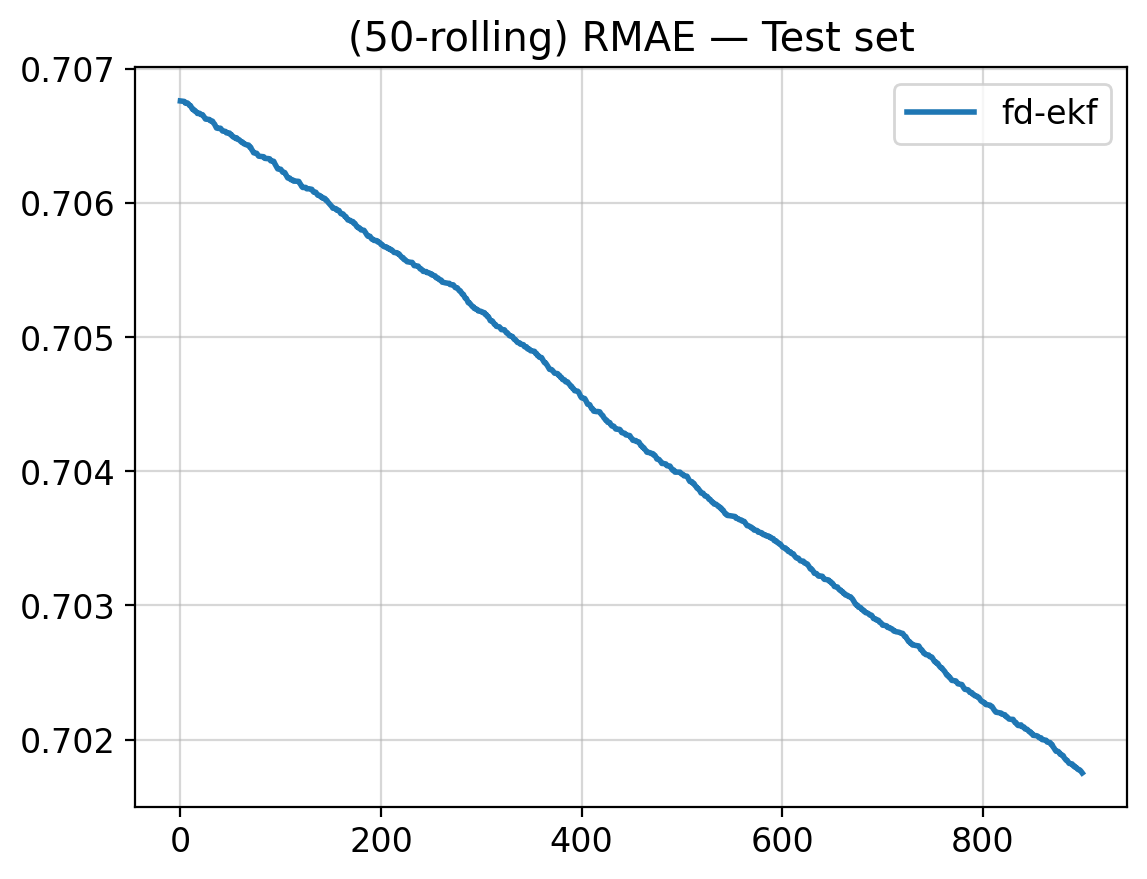

In [55]:
data.rolling(1).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

## 2.2 VDEKF

## 2.3 Orth-LoFi

## 2.4 Full-SVD-LoFi

In [24]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)

fs_lofi_optimizer, apply_fn, n_feats = hp_lofi.create_optimizer(
    cnn_model, pbounds, 314, warmup_01_train, warmup_01_test, params_lofi, 
    nll_callback, method, cnn_emission_mean_function, cnn_emission_cov_function
)

In [25]:
%%time
fs_lofi_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | dynami... | log_in... |
-------------------------------------------------
